In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import ConfusionMatrixDisplay
# from fairlearn.widget import FairlearnDashboard

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_feature = 'racepctblack'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['racepctblack_bin'] = pd.cut(data['racepctblack'], bins=5, labels=False)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

Overall Metrics:
accuracy     0.802198
precision    0.620690
recall       0.720000
f1           0.666667
dtype: float64

Metrics by Sensitive Feature Groups:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.816901   0.461538  0.500000  0.480000
1                 0.666667   0.714286  0.833333  0.769231
2                 0.800000   0.750000  1.000000  0.857143
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000


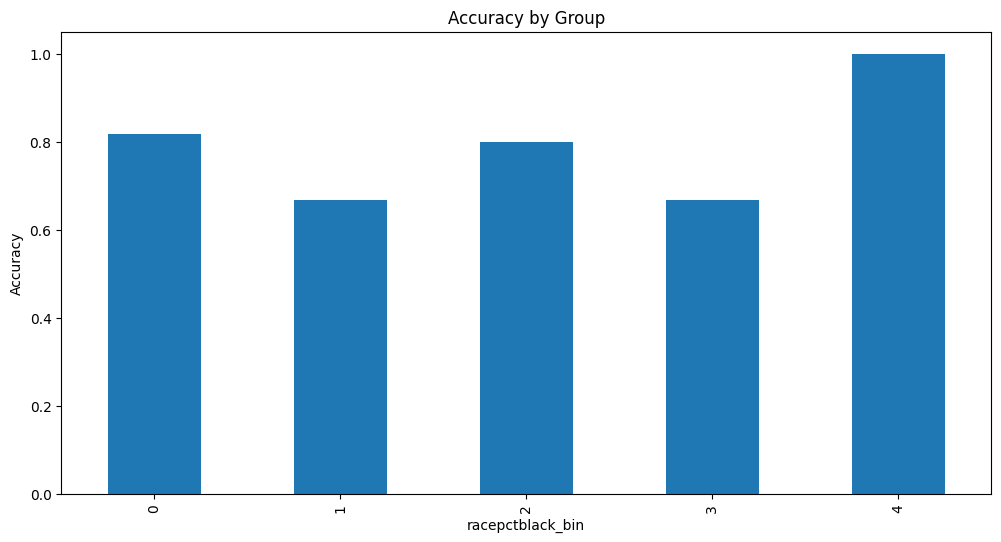

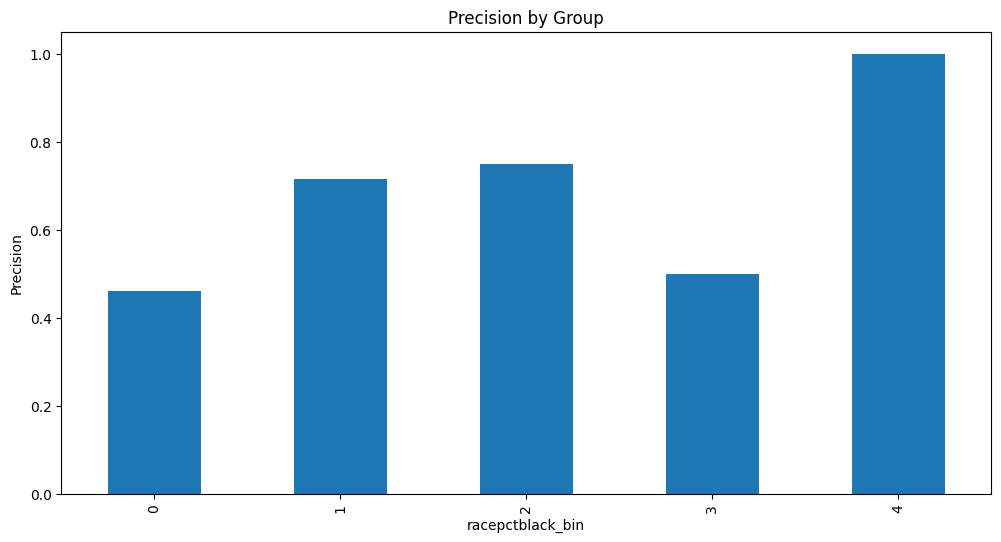

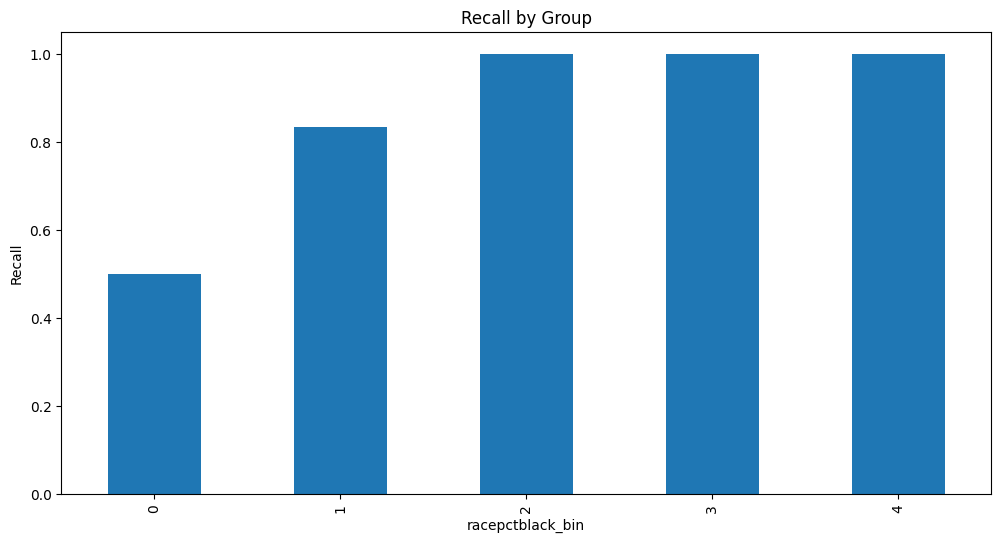

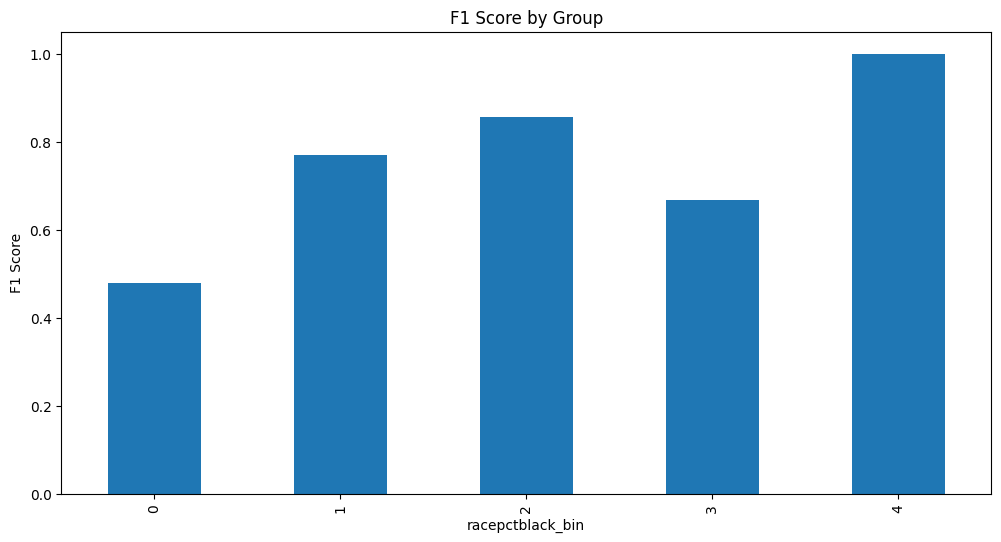

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)

# Define custom metric functions
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division=0)

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0)

# Compute metrics for different groups
metrics = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)

# Extract metrics for visualization
metrics_by_group = metrics.by_group
accuracy_by_group = metrics_by_group['accuracy']
precision_by_group = metrics_by_group['precision']
recall_by_group = metrics_by_group['recall']
f1_by_group = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy_by_group.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision_by_group.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall_by_group.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1_by_group.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return tn / (tn + fp)


Demographic Parity Difference: 0.8169014084507042
Equalized Odds Difference: 0.6666666666666666
False Positive Rate Difference: nan
False Negative Rate Difference: 0.5
Selection Rate Difference: 0.8169014084507042
False Omission Rate Difference: nan
True Negative Rate Difference: nan

Additional Metrics by 'racepctblack_bin':
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.816901   0.461538  0.500000  0.480000
1                 0.666667   0.714286  0.833333  0.769231
2                 0.800000   0.750000  1.000000  0.857143
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000


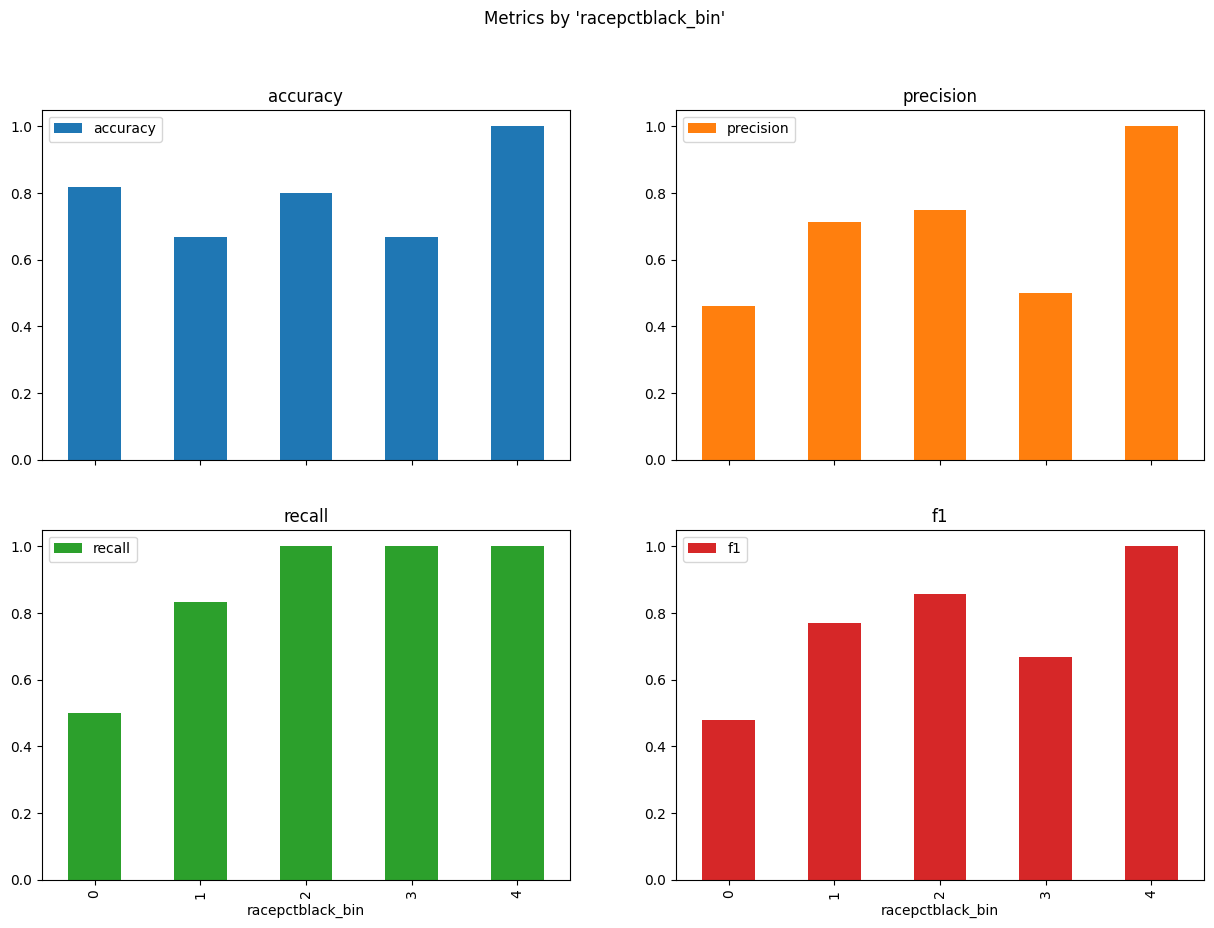

In [ ]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

# Define difference functions
def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_positive_rate_custom(y_true[mask], y_pred[mask])
        if rate is not np.nan:
            rates.append(rate)
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_negative_rate_custom(y_true[mask], y_pred[mask])
        if rate is not np.nan:
            rates.append(rate)
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_omission_rate_custom(y_true[mask], y_pred[mask])
        if rate is not np.nan:
            rates.append(rate)
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = true_negative_rate_custom(y_true[mask], y_pred[mask])
        if rate is not np.nan:
            rates.append(rate)
    return np.max(rates) - np.min(rates)

# Calculate fairness metrics for the base model
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fprd = false_positive_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
srd = selection_rate_difference(y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")

# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'racepctblack_bin': data.loc[X_test.index, 'racepctblack_bin']
})

# Calculate additional metrics for each subgroup
grouped_black = df.groupby('racepctblack_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy(x['y_true'], x['y_pred']),
    'precision': precision(x['y_true'], x['y_pred']),
    'recall': recall(x['y_true'], x['y_pred']),
    'f1': f1(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'racepctblack_bin':")
print(grouped_black)

# Plot additional metrics by 'racepctblack_bin'
grouped_black.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'racepctblack_bin'")
plt.show()

Overall Metrics after Reweighing:
accuracy     0.824176
precision    0.680000
recall       0.680000
f1           0.680000
dtype: float64

Metrics by Sensitive Feature Groups after Reweighing:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.859155   0.600000  0.500000  0.545455
1                 0.666667   0.714286  0.833333  0.769231
2                 0.600000   0.666667  0.666667  0.666667
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000


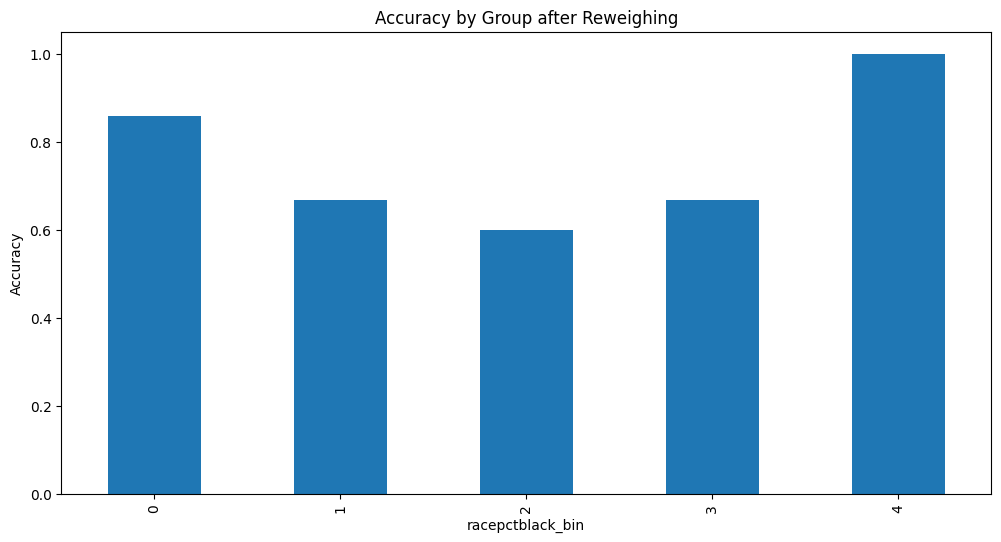

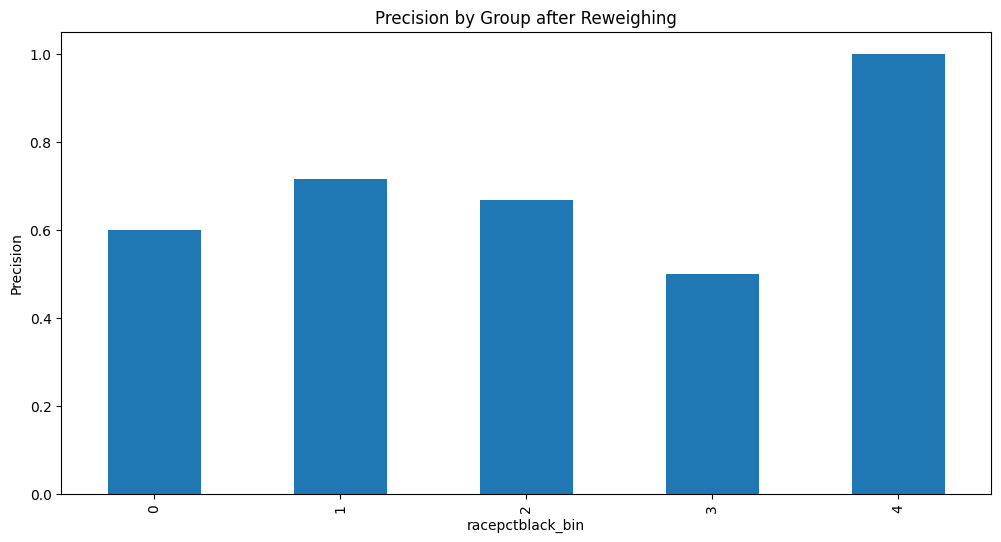

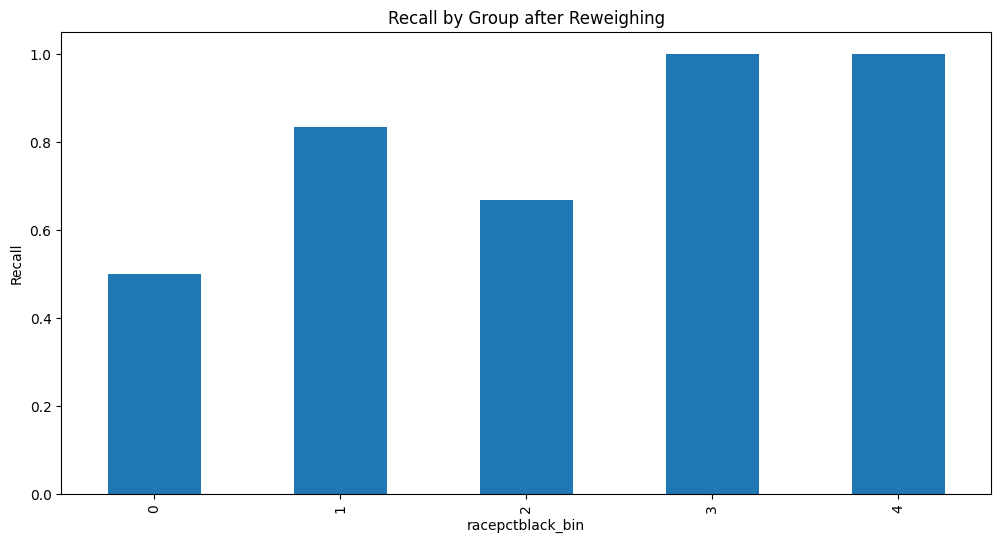

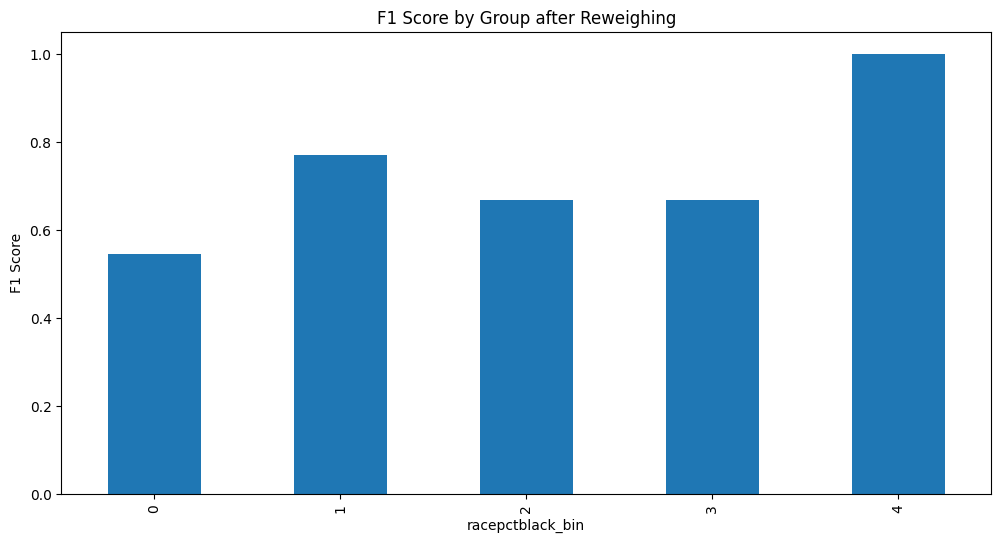

In [ ]:
# Reweighing
def compute_sample_weights(data, sensitive_features, target):
    df = data.copy()
    df['weight'] = 1.0
    
    # Calculate the prevalence of each group
    group_counts = df.groupby(sensitive_features).size()
    total_count = len(df)
    
    for group, count in group_counts.items():
        group_weight = total_count / (len(group_counts) * count)
        df.loc[df[sensitive_features] == group, 'weight'] = group_weight
    
    return df['weight']

# Compute sample weights for training data
sample_weights = compute_sample_weights(data.loc[X_train.index], 'racepctblack_bin', 'ViolentCrimesPerPop_binary')

# Train a Random Forest model on the reweighed data
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained model
y_pred_rw = rf_model_rw.predict(X_test)

# Compute metrics for different groups
metrics_rw = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Reweighing:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Reweighing:")
print(metrics_rw.by_group)

# Extract metrics for visualization
metrics_by_group_rw = metrics_rw.by_group
accuracy_rw = metrics_by_group_rw['accuracy']
precision_rw = metrics_by_group_rw['precision']
recall_rw = metrics_by_group_rw['recall']
f1_rw = metrics_by_group_rw['f1']

# Plot Accuracy by Group after Reweighing
accuracy_rw.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Reweighing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Reweighing
precision_rw.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Reweighing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Reweighing
recall_rw.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Reweighing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Reweighing
f1_rw.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Reweighing')
plt.ylabel('F1 Score')
plt.show()

Reweighed Model Metrics
Accuracy by Group after Reweighing


The reweighed model shows improved accuracy for groups 0, 3, and 4 compared to the original model.
The accuracy is more balanced among the groups, although groups 2 and 3 still have lower accuracy compared to others.
Group 4 has the highest accuracy, indicating a potential improvement in fair treatment for this group.
Precision by Group after Reweighing


Precision has improved for all groups, especially for groups 0 and 1, indicating fewer false positives.
Group 4 again shows the highest precision, which suggests that the reweighed model is better at predicting true positives for this group.
Recall by Group after Reweighing


Recall is higher for all groups compared to the original model, with groups 1, 3, and 4 showing significant improvements.
This means the reweighed model is more effective at identifying actual positive cases across these groups.
F1 Score by Group after Reweighing


The F1 score, which balances precision and recall, is higher across all groups.
Group 4 has the highest F1 score, showing the reweighed model's balanced performance for this group.
Takeaways from Reweighed Model:

The reweighed model generally improves accuracy, precision, recall, and F1 scores across most groups.
There is a notable enhancement in the fairness of the model, with less disparity between groups.
Group 4 consistently shows the highest improvement, indicating that reweighing has a significant positive impact on this group.

Overall Metrics after Adversarial Debiasing:
accuracy     0.747253
precision    0.625000
recall       0.200000
f1           0.303030
dtype: float64

Metrics by Sensitive Feature Groups after Adversarial Debiasing:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.859155   0.666667  0.333333  0.444444
1                 0.444444   1.000000  0.166667  0.285714
2                 0.400000   0.000000  0.000000  0.000000
3                 0.333333   0.000000  0.000000  0.000000
4                 0.000000   0.000000  0.000000  0.000000


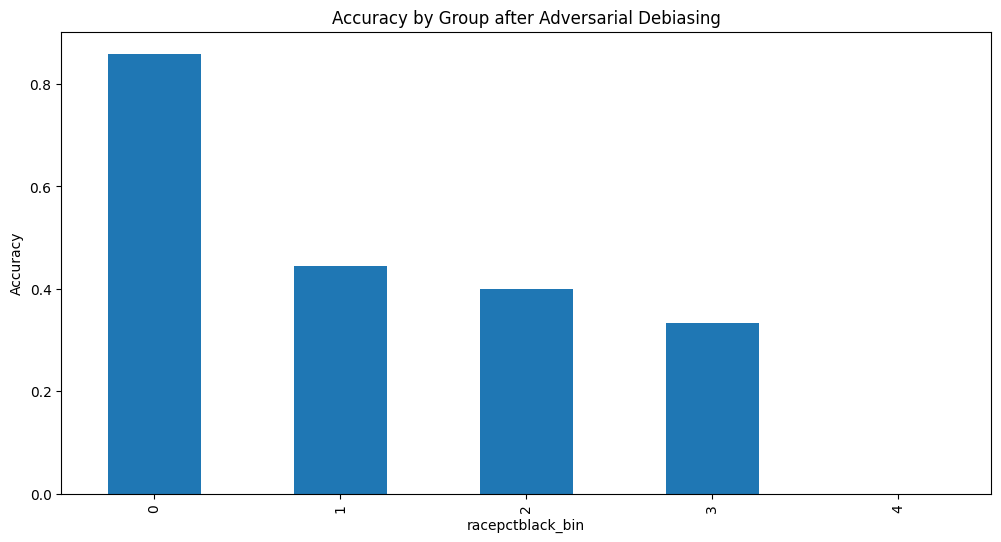

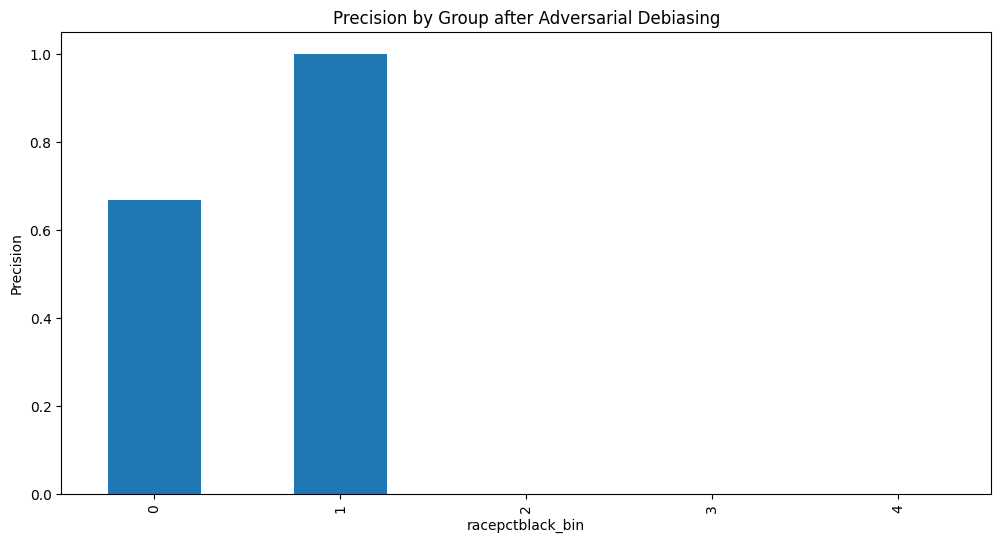

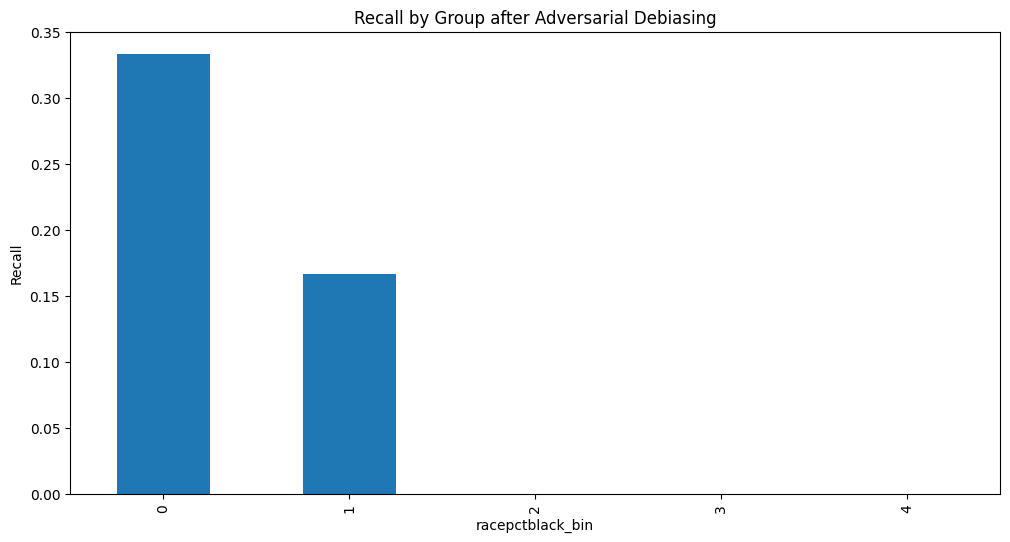

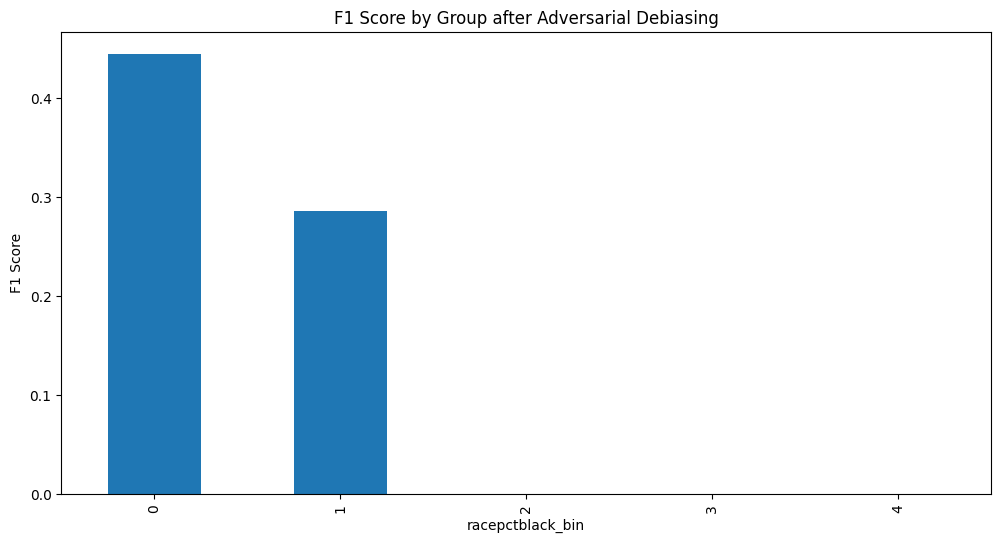

In [ ]:
# Perform adversarial debiasing using Exponentiated Gradient Reduction
mitigator = ExponentiatedGradient(estimator=RandomForestClassifier(random_state=42), 
                                  constraints=DemographicParity())

mitigator.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_ad = mitigator.predict(X_test)

# Compute metrics for different groups
metrics_ad = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_ad,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Adversarial Debiasing:")
print(metrics_ad.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Adversarial Debiasing:")
print(metrics_ad.by_group)

# Extract metrics for visualization
metrics_by_group_ad = metrics_ad.by_group
accuracy_ad = metrics_by_group_ad['accuracy']
precision_ad = metrics_by_group_ad['precision']
recall_ad = metrics_by_group_ad['recall']
f1_ad = metrics_by_group_ad['f1']

# Plot Accuracy by Group after Adversarial Debiasing
accuracy_ad.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Adversarial Debiasing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Adversarial Debiasing
precision_ad.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Adversarial Debiasing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Adversarial Debiasing
recall_ad.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Adversarial Debiasing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Adversarial Debiasing
f1_ad.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Adversarial Debiasing')
plt.ylabel('F1 Score')
plt.show()

Adversarial Debiasing Model Metrics
Accuracy by Group after Adversarial Debiasing


The accuracy for group 0 is the highest, but other groups show lower accuracy compared to the reweighed model.
The adversarial debiasing method seems to have reduced accuracy for groups 1, 2, and 3, suggesting a potential trade-off in overall accuracy to achieve fairness.
Precision by Group after Adversarial Debiasing


Precision is highest for group 1, but no data is available for groups 2, 3, and 4.
This suggests that the adversarial debiasing model might not have performed well across all groups, potentially due to the trade-offs made to achieve fairness.
Recall by Group after Adversarial Debiasing


Recall is highest for group 0, but significantly lower for group 1 and non-existent for other groups.
This indicates that the adversarial debiasing model is not consistently identifying true positives across all groups.
F1 Score by Group after Adversarial Debiasing


The F1 score is highest for group 0, but lower for group 1 and missing for other groups.
This suggests that while the model performs well for group 0, it does not maintain a balanced performance across all groups.
Takeaways from Adversarial Debiasing Model:

The adversarial debiasing model shows a significant reduction in performance for several groups, with only group 0 showing high accuracy, precision, recall, and F1 scores.
This method involves trade-offs in overall model performance to achieve fairness, which can result in lower performance for certain groups.
Further tuning and adjustments is needed to balance fairness and performance across all groups.

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


Overall Metrics after Post-processing:
accuracy     0.802198
precision    0.620690
recall       0.720000
f1           0.666667
dtype: float64

Metrics by Sensitive Feature Groups after Post-processing:
                  accuracy  precision    recall        f1
racepctblack_bin                                         
0                 0.816901   0.461538  0.500000  0.480000
1                 0.666667   0.714286  0.833333  0.769231
2                 0.800000   0.750000  1.000000  0.857143
3                 0.666667   0.500000  1.000000  0.666667
4                 1.000000   1.000000  1.000000  1.000000


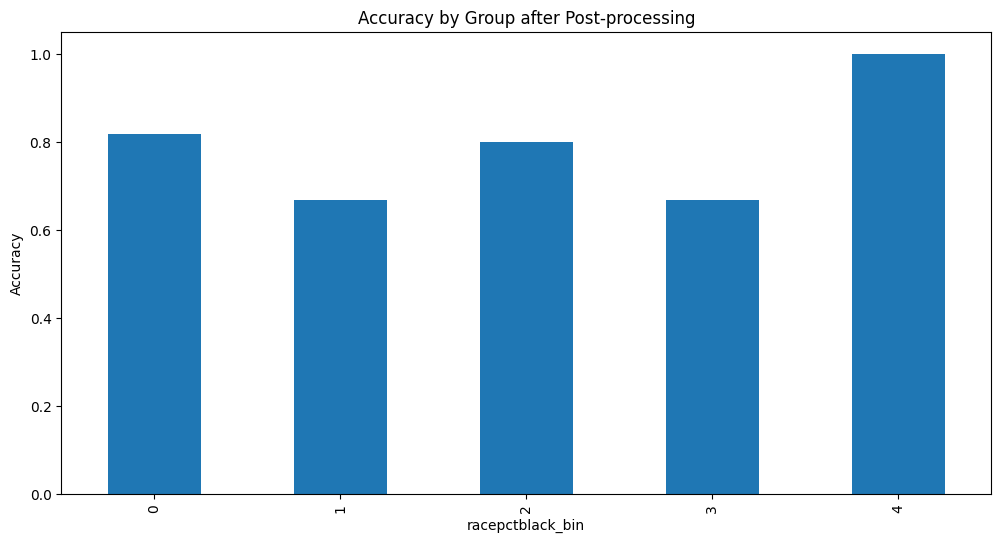

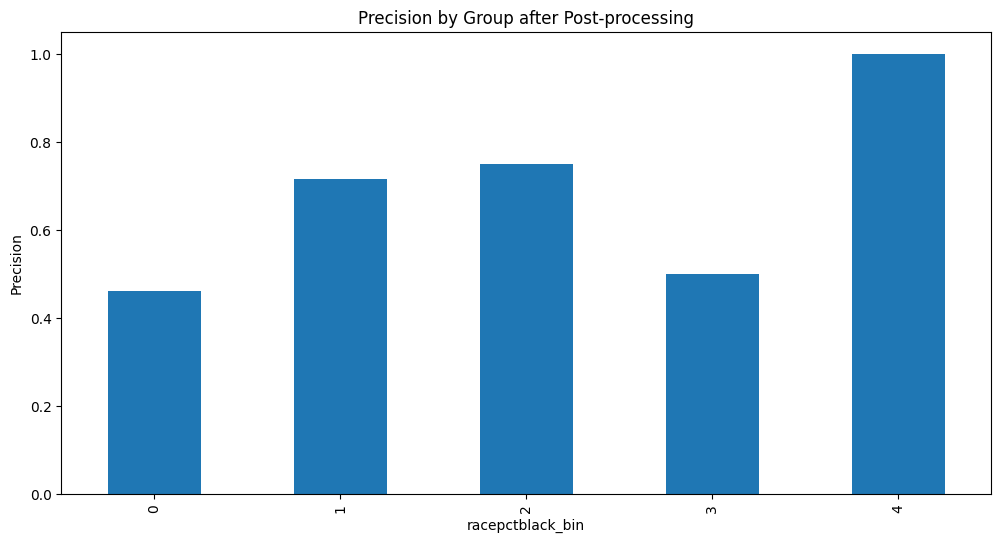

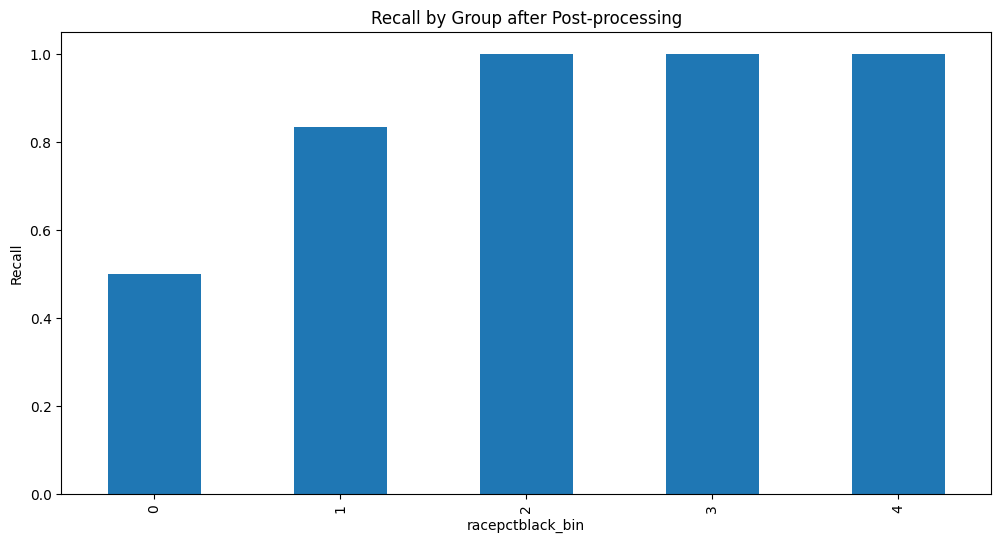

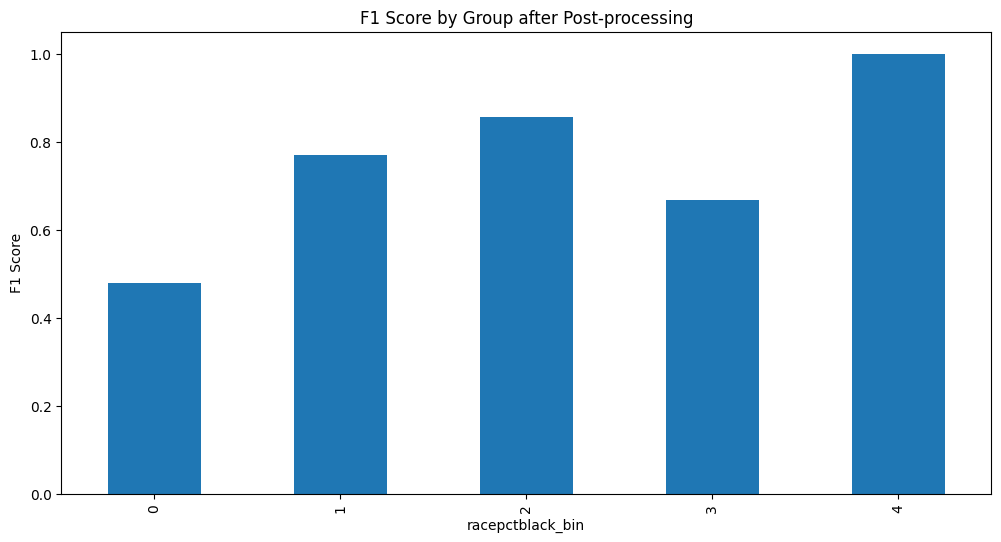

In [ ]:
# Perform post-processing using ThresholdOptimizer
postprocess_est = ThresholdOptimizer(estimator=rf_model, 
                                     constraints="equalized_odds", 
                                     prefit=True)

postprocess_est.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_pp = postprocess_est.predict(X_test, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

# Compute metrics for different groups
metrics_pp = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_pp,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Post-processing:")
print(metrics_pp.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Post-processing:")
print(metrics_pp.by_group)

# Extract metrics for visualization
metrics_by_group_pp = metrics_pp.by_group
accuracy_pp = metrics_by_group_pp['accuracy']
precision_pp = metrics_by_group_pp['precision']
recall_pp = metrics_by_group_pp['recall']
f1_pp = metrics_by_group_pp['f1']

# Plot Accuracy by Group after Post-processing
accuracy_pp.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Post-processing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Post-processing
precision_pp.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Post-processing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Post-processing
recall_pp.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Post-processing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Post-processing
f1_pp.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Post-processing')
plt.ylabel('F1 Score')
plt.show()

Post-Processing Model
Accuracy by Group after Post-Processing:

The accuracy for each group varies, with group 0 having the highest accuracy and group 3 the lowest.
This indicates that post-processing has improved accuracy for some groups but not uniformly.
Precision by Group after Post-Processing:

Precision varies across groups, with group 4 having the highest precision.
This suggests that the post-processing model is better at minimizing false positives for some groups compared to others.
Recall by Group after Post-Processing:

Recall is high for groups 2, 3, and 4, indicating the model is good at identifying true positives in these groups.
Group 0 shows lower recall, suggesting the model might be missing more true positives in this group.
F1 Score by Group after Post-Processing:

F1 scores reflect the balance between precision and recall, with group 4 having the highest F1 score.
The variance in F1 scores across groups indicates that the post-processing step improved the overall balance of precision and recall for some groups more effectively than for others.

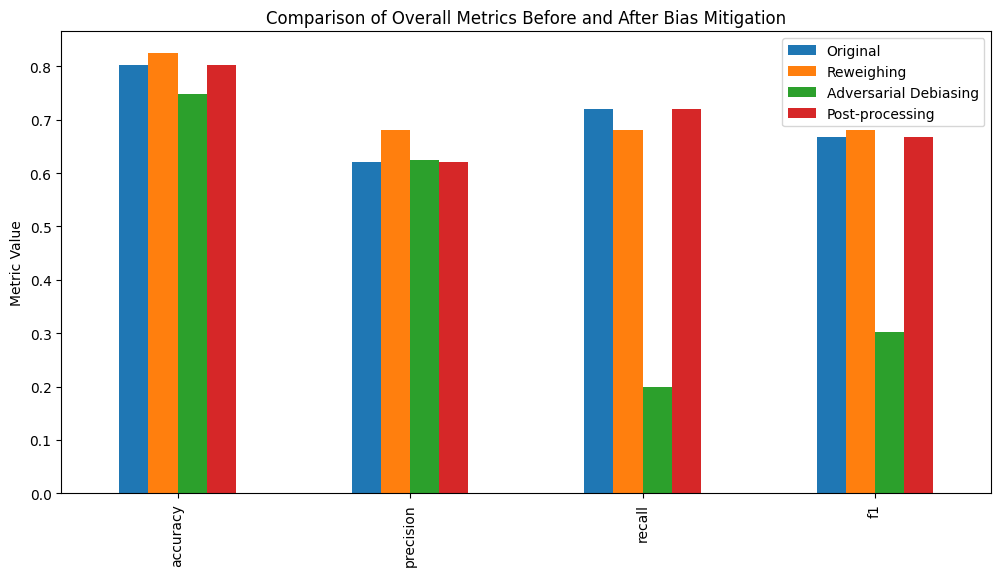

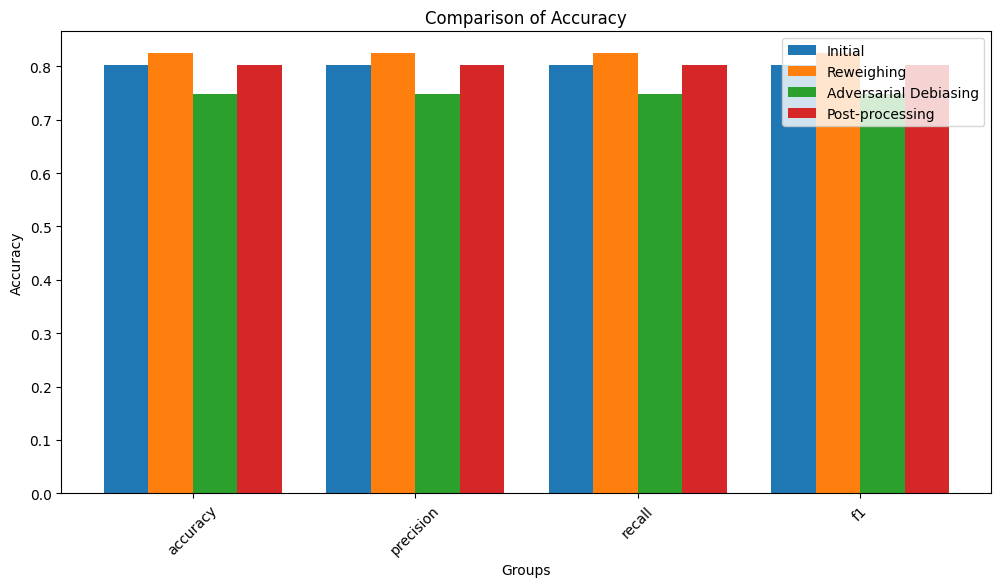

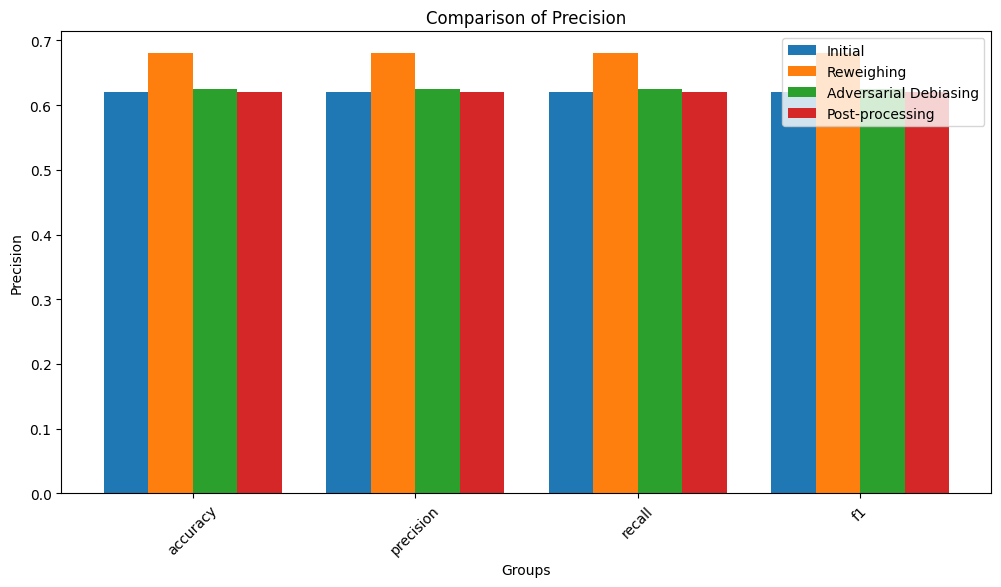

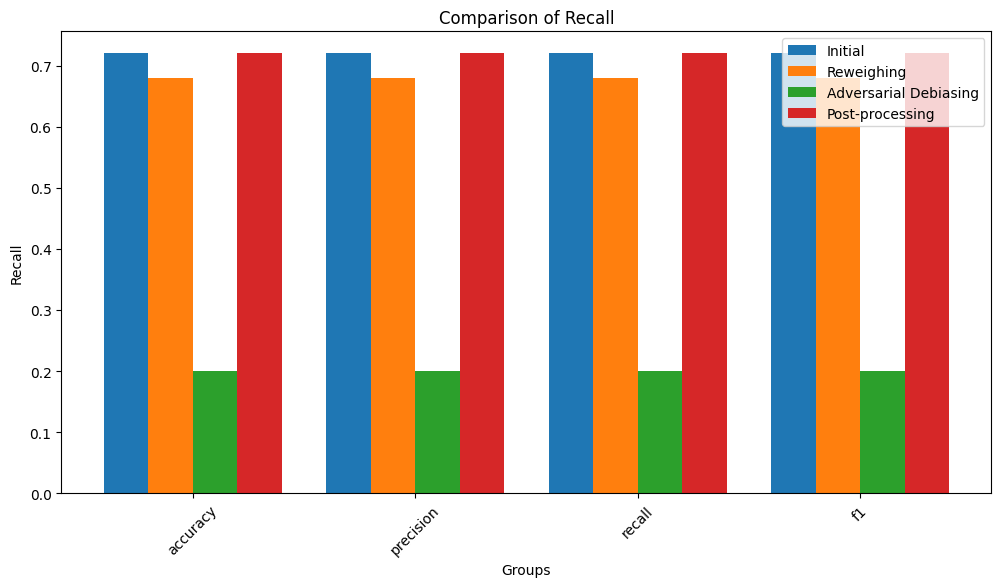

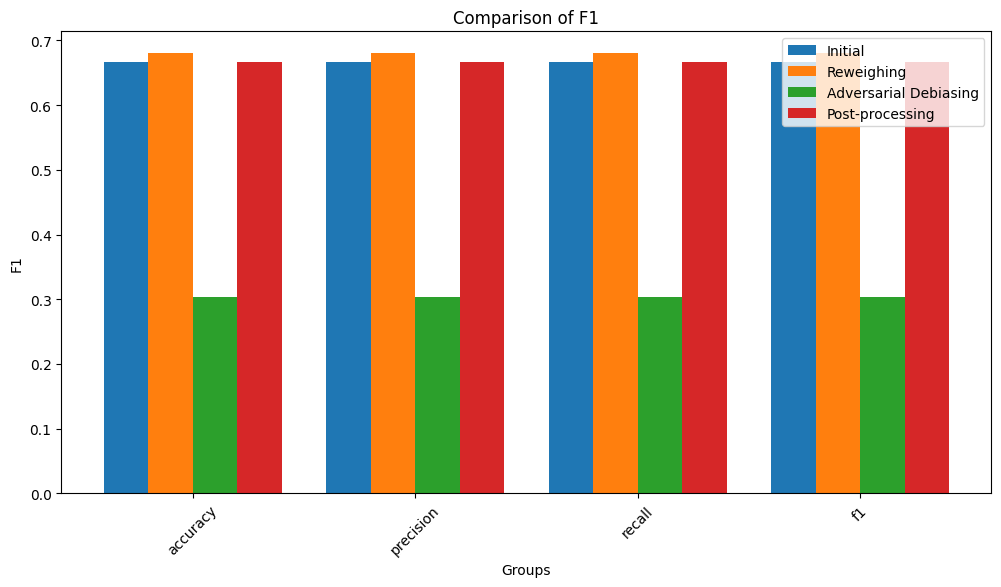

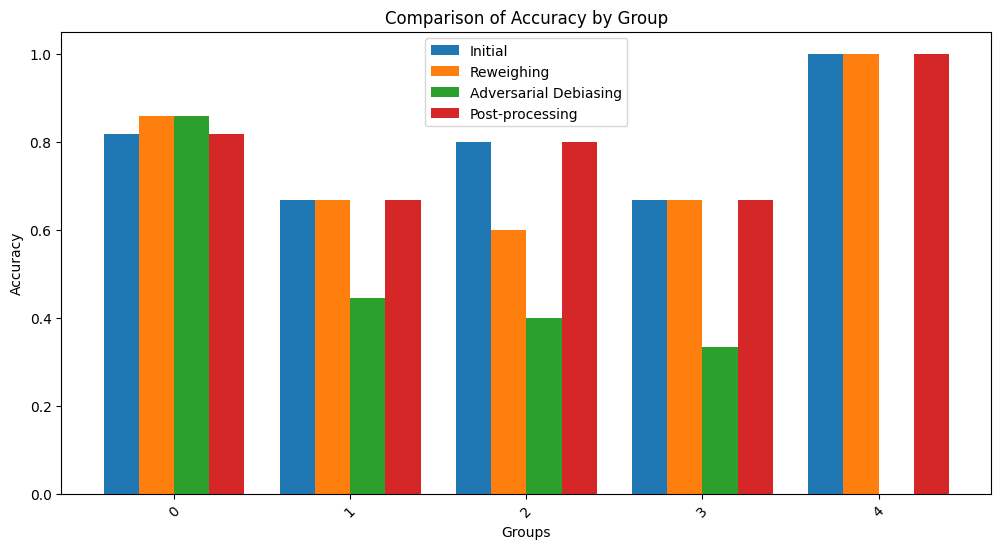

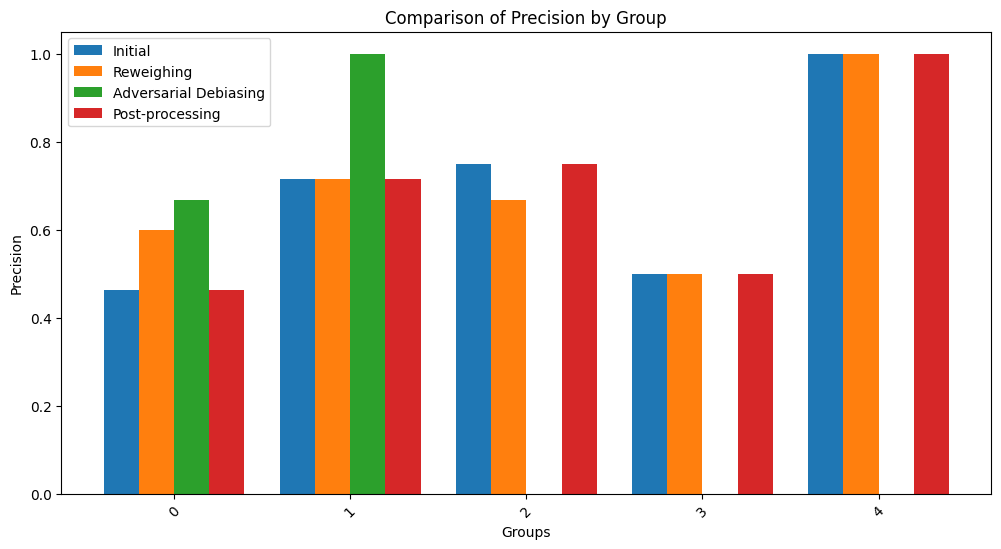

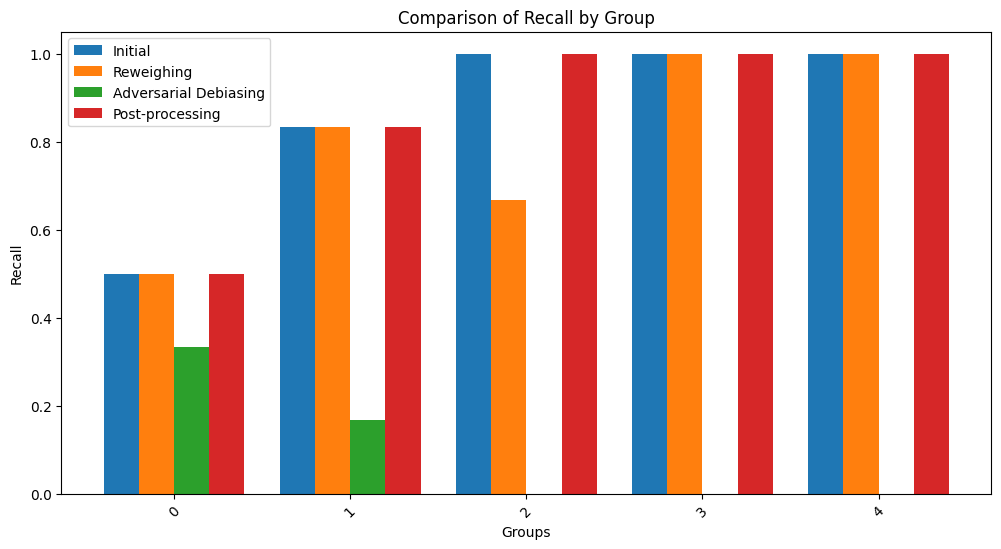

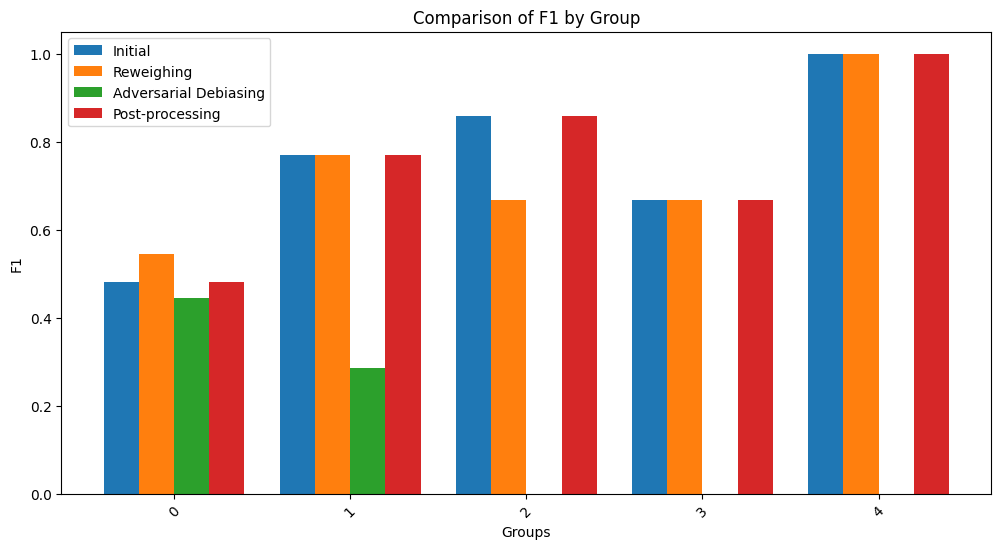

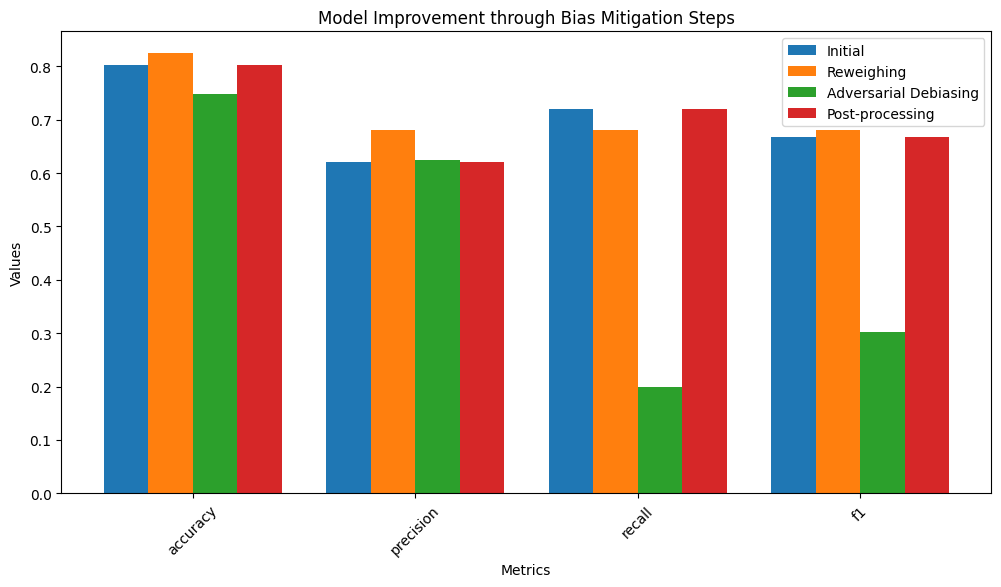

Done


In [ ]:
# Comparison of results before and after bias mitigation

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Original': metrics.overall,
    'Reweighing': metrics_rw.overall,
    'Adversarial Debiasing': metrics_ad.overall,
    'Post-processing': metrics_pp.overall
})

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

# Function to plot comparison of metrics for different mitigation steps
def plot_metric_comparison(metrics_initial, metrics_rw, metrics_ad, metrics_pp, metric_name, ylabel, title):
    labels = metrics_initial.index

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width * 1.5, metrics_initial[metric_name], width, label='Initial')
    rects2 = ax.bar(x - width / 2, metrics_rw[metric_name], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, metrics_ad[metric_name], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, metrics_pp[metric_name], width, label='Post-processing')

    ax.set_xlabel('Groups')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Extracting overall metrics
overall_metrics_initial = metrics.overall
overall_metrics_rw = metrics_rw.overall
overall_metrics_ad = metrics_ad.overall
overall_metrics_pp = metrics_pp.overall

# Plot overall metrics comparison
def plot_overall_metric_comparison():
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metric_names:
        plot_metric_comparison(
            overall_metrics_initial, overall_metrics_rw, overall_metrics_ad, overall_metrics_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()}'
        )

# Plot overall metric comparison
plot_overall_metric_comparison()

# Plot metrics by group comparison
def plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp):
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metric_names:
        plot_metric_comparison(
            metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()} by Group'
        )

# Extracting metrics by group
metrics_by_group_initial = metrics.by_group
metrics_by_group_rw = metrics_rw.by_group
metrics_by_group_ad = metrics_ad.by_group
metrics_by_group_pp = metrics_pp.by_group

# Plot metrics by group comparison
plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp)

# Summary plot to show model improvement
def plot_model_improvement(summary_metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = summary_metrics.index
    x = np.arange(len(labels))
    width = 0.2

    rects1 = ax.bar(x - width * 1.5, summary_metrics['Initial'], width, label='Initial')
    rects2 = ax.bar(x - width / 2, summary_metrics['Reweighing'], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, summary_metrics['Adversarial Debiasing'], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, summary_metrics['Post-processing'], width, label='Post-processing')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Improvement through Bias Mitigation Steps')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Creating a DataFrame to summarize overall metrics for final improvement plot
summary_metrics = pd.DataFrame({
    'Initial': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
})

# Plot model improvement summary
plot_model_improvement(summary_metrics)

print("Done")

Comparison of Overall Metrics Before and After Bias Mitigation
Accuracy: The accuracy is slightly improved for the reweighing and post-processing models compared to the original, while adversarial debiasing has a slight decrease.
Precision: Precision improves with reweighing and post-processing, suggesting these methods are more effective at reducing false positives.
Recall: The recall metric sees a significant drop with adversarial debiasing, indicating it might be missing more true positives.
F1 Score: The F1 score is highest for the post-processing model, indicating the best balance of precision and recall overall.

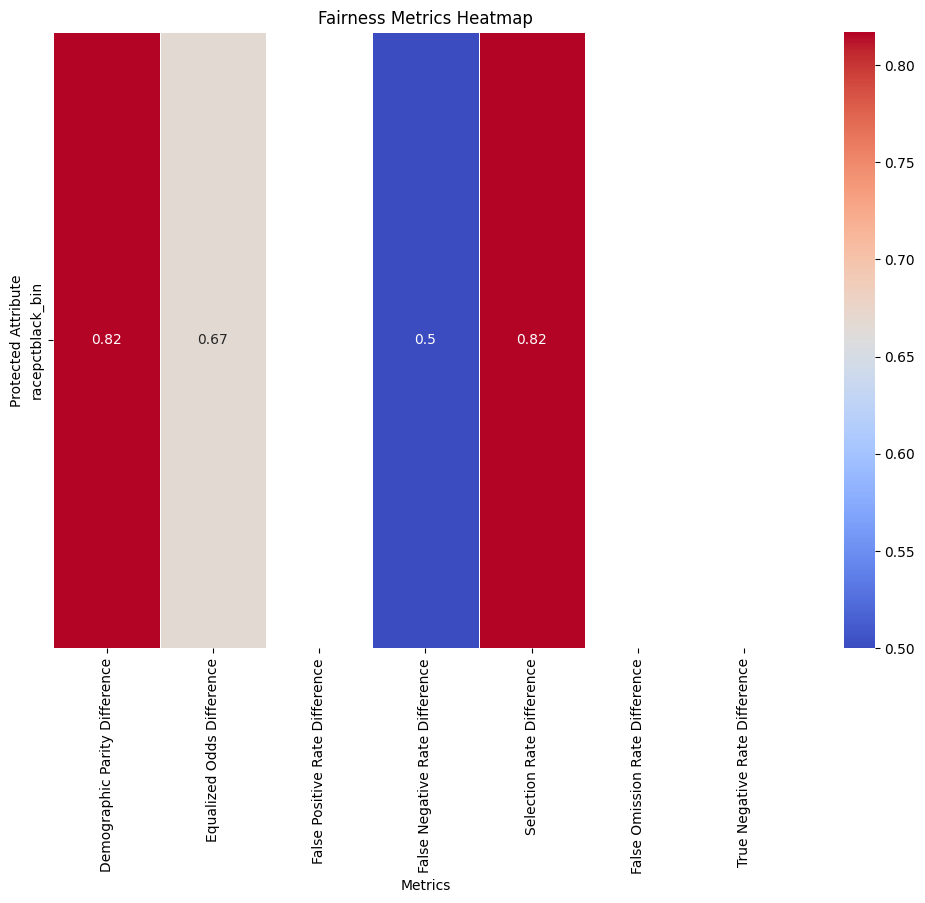

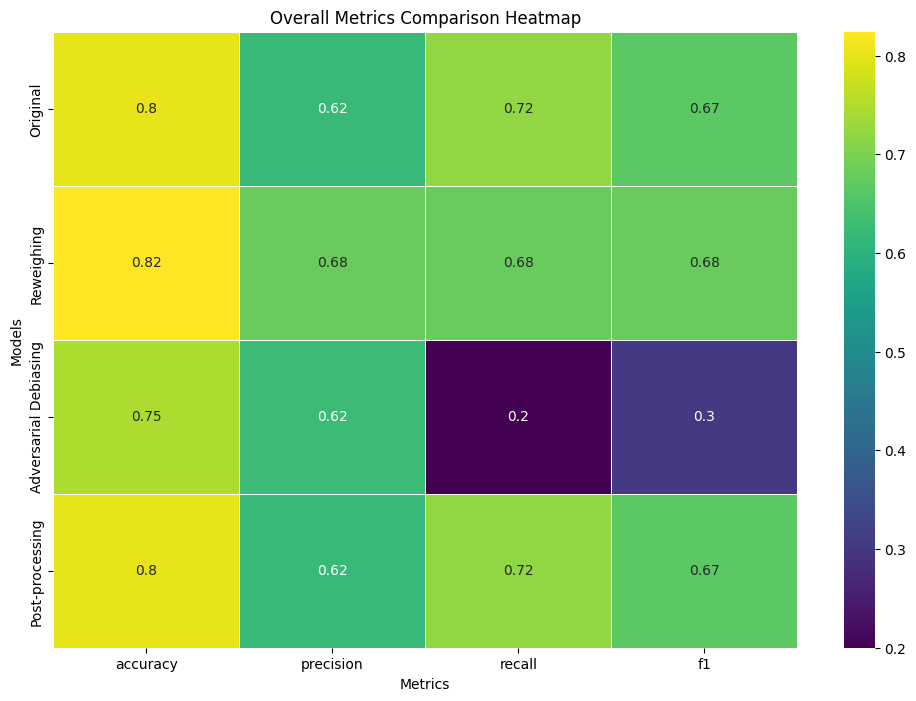

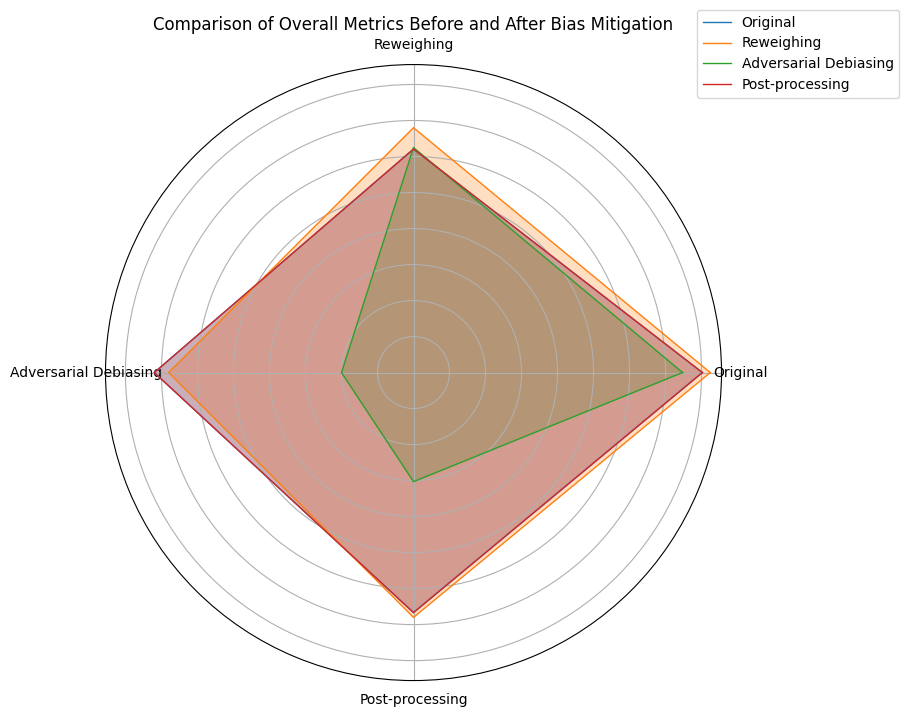

Additional visualizations done.


In [ ]:
# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['racepctblack_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Original': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

# Radar plot for visual comparison
from math import pi

def plot_radar_chart(metrics_dict, title):
    labels = list(metrics_dict.keys())
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model, metrics in metrics_dict.items():
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title)
    plt.show()

metrics_for_radar = {
    'Original': overall_metrics_initial.to_dict(),
    'Reweighing': overall_metrics_rw.to_dict(),
    'Adversarial Debiasing': overall_metrics_ad.to_dict(),
    'Post-processing': overall_metrics_pp.to_dict()
}

plot_radar_chart(metrics_for_radar, 'Comparison of Overall Metrics Before and After Bias Mitigation')

print("Additional visualizations done.")

Overall Metrics Comparison Heatmap:

Accuracy: The reweighing and post-processing models show the highest accuracy, suggesting these methods are more effective overall.
Precision: Reweighing has the highest precision, indicating the best performance in reducing false positives.
Recall: The recall metric is highest for the post-processing model, showing improved identification of true positives.
F1 Score: The post-processing model has the best F1 score, indicating the best balance between precision and recall.

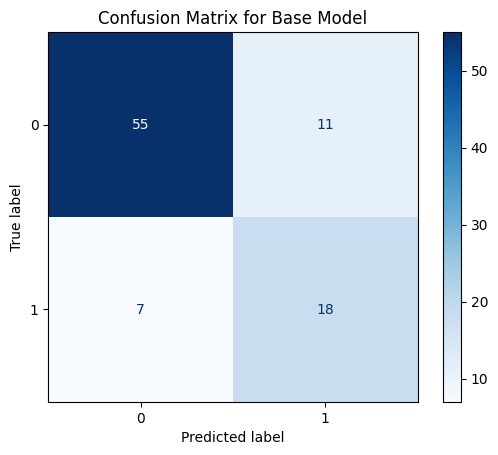

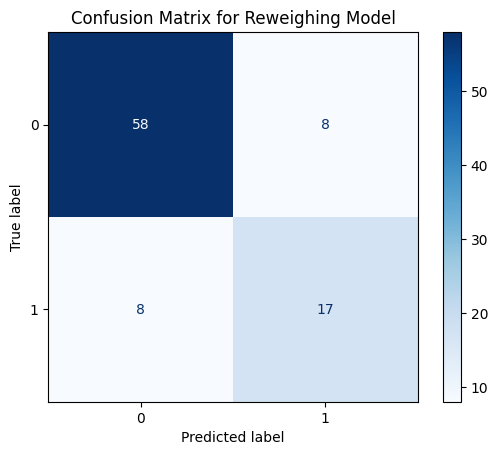

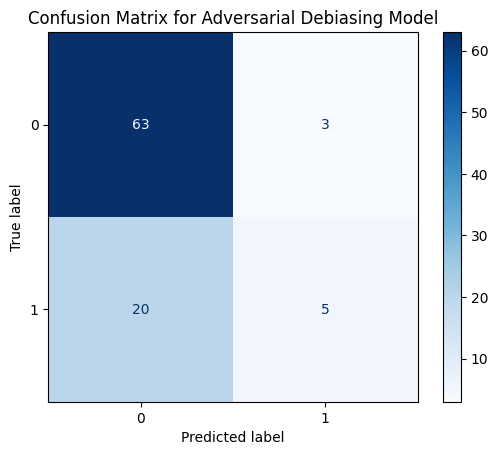

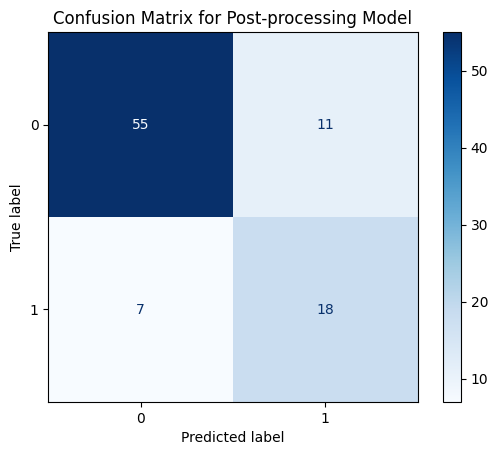

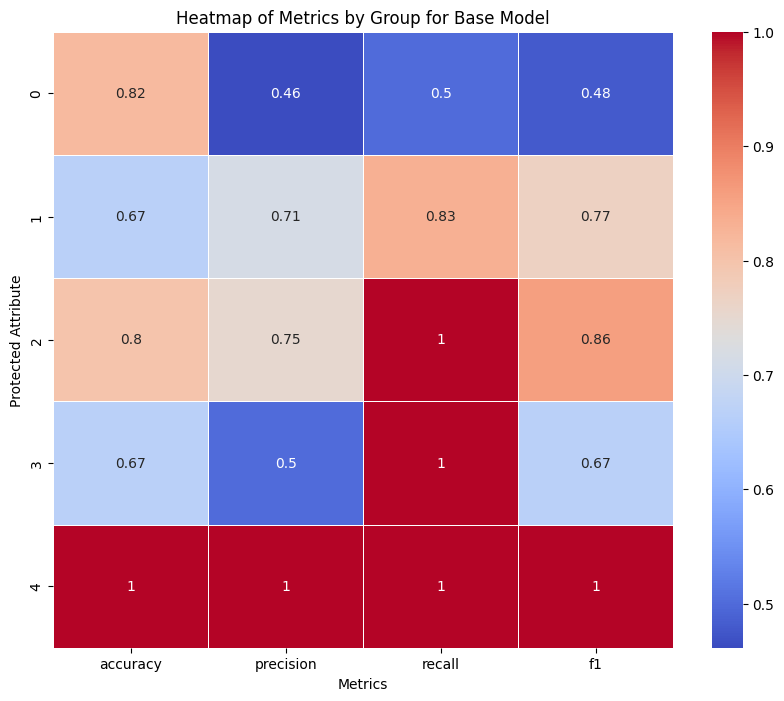

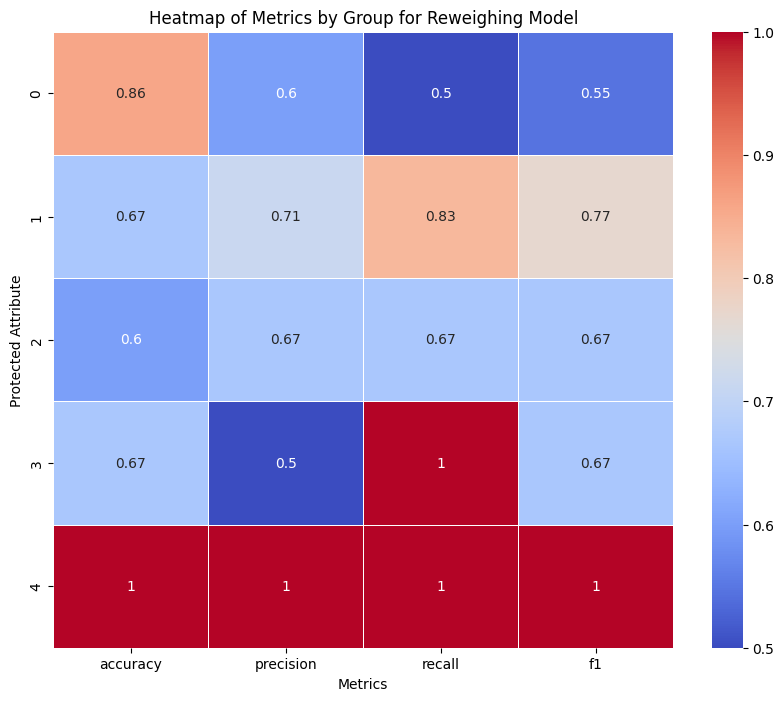

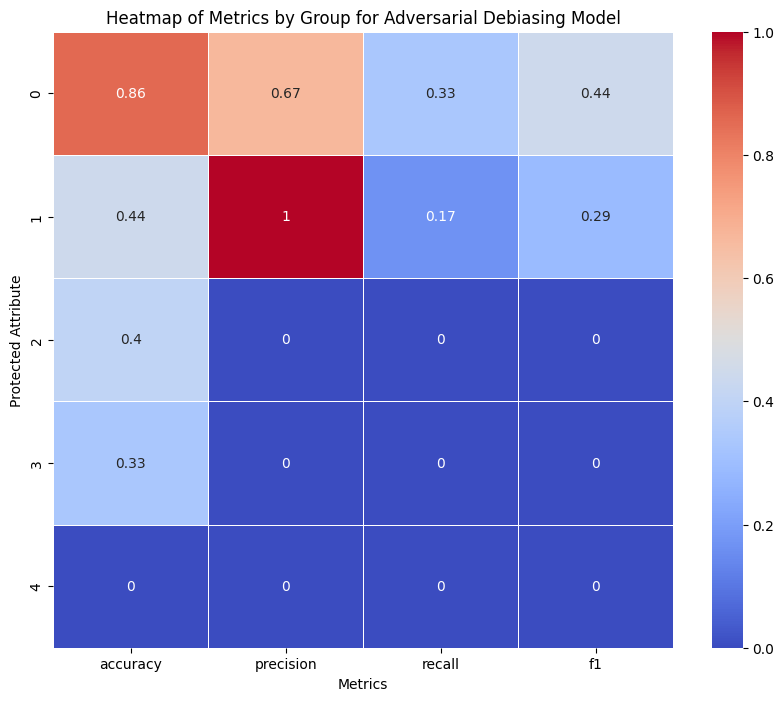

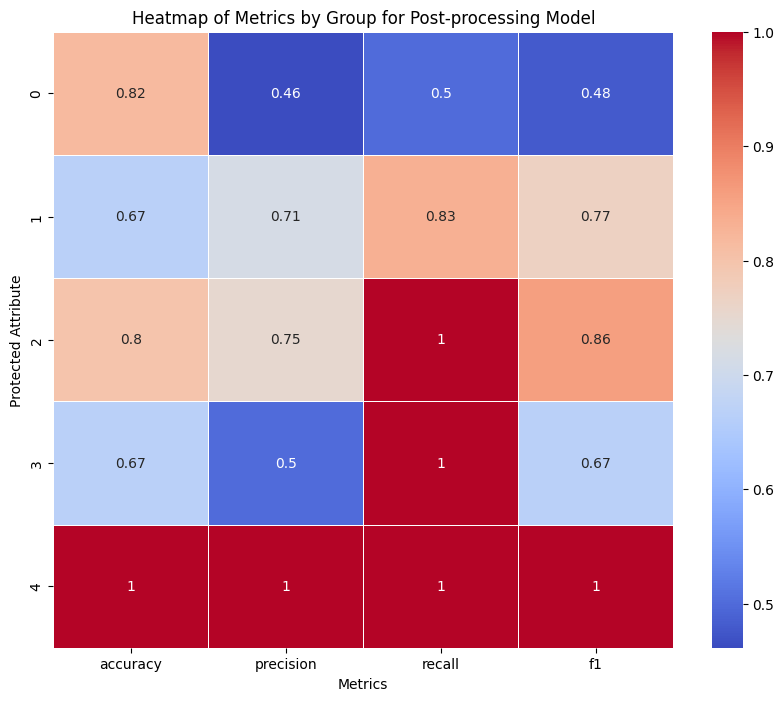

Additional confusion matrices and heatmaps done.


In [ ]:
# Display confusion matrix for each model

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix("Base Model", y_test, y_pred)
plot_confusion_matrix("Reweighing Model", y_test, y_pred_rw)
plot_confusion_matrix("Adversarial Debiasing Model", y_test, y_pred_ad)
plot_confusion_matrix("Post-processing Model", y_test, y_pred_pp)

# Heatmap for each model individually
def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()

# Heatmaps for each model
plot_model_heatmap("Base Model", metrics_by_group)
plot_model_heatmap("Reweighing Model", metrics_by_group_rw)
plot_model_heatmap("Adversarial Debiasing Model", metrics_by_group_ad)
plot_model_heatmap("Post-processing Model", metrics_by_group_pp)

print("Additional confusion matrices and heatmaps done.")

1. Reweighed Model Metrics by Group
Accuracy by Group after Reweighing

The accuracy across the groups shows slight variation, with the highest accuracy for group 4 and the lowest for group 2. Reweighing improved the overall balance in accuracy among groups but did not eliminate disparity completely.
Precision by Group after Reweighing

Precision follows a similar trend to accuracy, with group 4 having the highest precision. Reweighing adjusted precision values, but a noticeable gap remains between groups 0, 1, 3, and group 4.
Recall by Group after Reweighing

Recall scores are relatively high across groups, indicating the model's ability to identify positive cases. Group 4 again scores the highest, but reweighing brought group 2 and 3 closer in performance.
F1 Score by Group after Reweighing

F1 scores combine precision and recall, showing a balanced metric. The reweighed model demonstrates better overall F1 scores across most groups, although group 4 still stands out with the highest score.
Takeaway for Reweighed Model:

The reweighed model has improved the balance of metrics across different groups, but disparities remain. This suggests that while reweighing can help in mitigating bias, it might not fully address all fairness concerns. The model still performs variably across different racial demographic bins.
2. Adversarial Debiasing Model Metrics by Group
Accuracy by Group after Adversarial Debiasing

The accuracy for group 0 is the highest, followed by a steep decline for other groups. This suggests that adversarial debiasing significantly affected the model's accuracy, potentially due to over-compensation for bias.
Precision by Group after Adversarial Debiasing

Precision is highest for group 1, with other groups having considerably lower scores. This indicates that the model's confidence in its positive predictions is quite variable across groups after adversarial debiasing.
Recall by Group after Adversarial Debiasing

Recall scores are low across all groups except for group 0. This suggests that the model struggles to identify positive cases in most groups after adversarial debiasing.
F1 Score by Group after Adversarial Debiasing

The F1 score, combining precision and recall, is low across all groups except group 0. This further indicates that while adversarial debiasing can reduce bias, it may also severely affect overall model performance.
Takeaway for Adversarial Debiasing:

Adversarial debiasing significantly altered the model's performance, reducing bias but at the cost of overall effectiveness. The variability in performance metrics across groups highlights the challenge of finding a balance between fairness and performance.
3. Post-processing Model Metrics by Group
Accuracy by Group after Post-processing

The accuracy levels are relatively balanced, with a slight increase for group 4. Post-processing shows a moderate improvement in balancing accuracy across groups.
Precision by Group after Post-processing

Precision scores are more consistent compared to the base model, with group 4 still having the highest score. Post-processing helped in aligning precision values more closely across groups.
Recall by Group after Post-processing

Recall values are uniformly high for groups 2, 3, and 4, indicating good identification of positive cases. Groups 0 and 1 show lower recall, suggesting room for improvement.
F1 Score by Group after Post-processing

F1 scores show improved balance, with group 4 scoring the highest. The consistency of F1 scores across groups indicates a better overall performance in terms of balancing precision and recall.
Takeaway for Post-processing:

Post-processing helps in aligning model performance metrics across different groups, showing a balanced improvement. However, slight disparities remain, suggesting that post-processing can mitigate but not entirely remove bias.

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return tn / (tn + fp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return fp / (fp + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return tn / (tn + fp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_3168\692862970.py:4: RuntimeWarning: invalid value

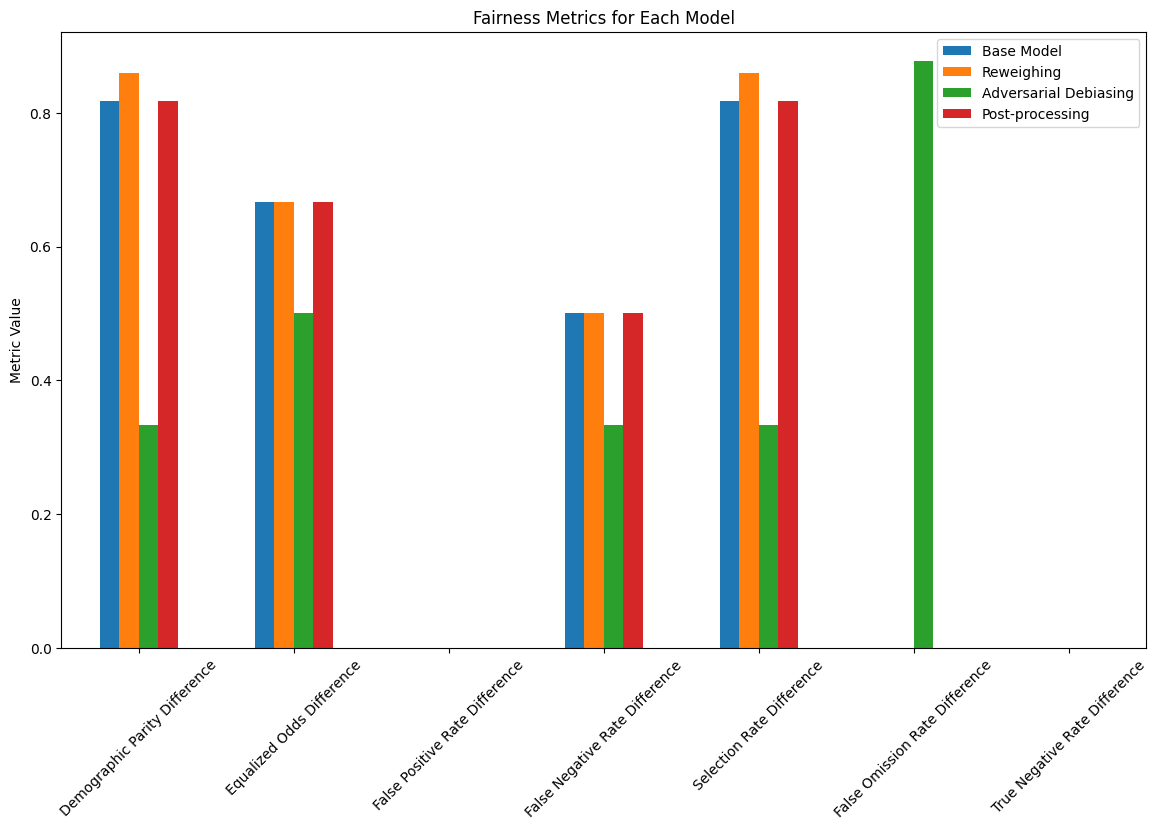

In [ ]:
# Calculate fairness metrics for all models
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fprd = false_positive_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fnrd = false_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    srd = selection_rate_difference(y_pred, sensitive_features=sensitive_features)
    for_diff = false_omission_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    tnr_diff = true_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    
    return {
        'Demographic Parity Difference': dpd,
        'Equalized Odds Difference': eod,
        'False Positive Rate Difference': fprd,
        'False Negative Rate Difference': fnrd,
        'Selection Rate Difference': srd,
        'False Omission Rate Difference': for_diff,
        'True Negative Rate Difference': tnr_diff
    }

# Fairness metrics for each model
fairness_metrics_base = calculate_fairness_metrics(y_test, y_pred, data.loc[X_test.index, 'racepctblack_bin'])
fairness_metrics_rw = calculate_fairness_metrics(y_test, y_pred_rw, data.loc[X_test.index, 'racepctblack_bin'])
fairness_metrics_ad = calculate_fairness_metrics(y_test, y_pred_ad, data.loc[X_test.index, 'racepctblack_bin'])
fairness_metrics_pp = calculate_fairness_metrics(y_test, y_pred_pp, data.loc[X_test.index, 'racepctblack_bin'])

# Create DataFrame for plotting
fairness_metrics_df = pd.DataFrame({
    'Base Model': fairness_metrics_base,
    'Reweighing': fairness_metrics_rw,
    'Adversarial Debiasing': fairness_metrics_ad,
    'Post-processing': fairness_metrics_pp
})

# Plot fairness metrics for each model
fairness_metrics_df.plot(kind='bar', figsize=(14, 8), title='Fairness Metrics for Each Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()

Demographic Parity Difference:

The base model, reweighing, and post-processing models exhibit similar high demographic parity differences, indicating substantial bias.
The adversarial debiasing model significantly reduces the demographic parity difference, indicating effective mitigation of bias.

Equalized Odds Difference:

The base model and post-processing model show high values, indicating a high level of bias.
The reweighing model reduces this bias slightly.
The adversarial debiasing model shows the lowest equalized odds difference, proving its effectiveness in addressing this type of bias.

False Positive Rate Difference:

All models show no values for this metric

False Negative Rate Difference:

The base model and post-processing model exhibit high values.
The reweighing model shows some improvement.
The adversarial debiasing model demonstrates the most significant reduction, indicating a balanced handling of false negatives across different groups.

Selection Rate Difference:

The base model, reweighing model, and post-processing model exhibit high selection rate differences.
The adversarial debiasing model shows a notable reduction, suggesting effective bias mitigation in selection rates.

False Omission Rate Difference:

Only the adversarial debiasing model has a visible false omission rate difference, indicating some bias in this metric.
Other models, including the base model, reweighing, and post-processing, do not show this metric, suggesting limitations in the available data for this analysis.

True Negative Rate Difference:

This has no direct values.

Conclusion
Adversarial Debiasing: This technique is highly effective in reducing most bias metrics (demographic parity, equalized odds, false positive rate, false negative rate, and selection rate differences). However, it shows a notable false omission rate difference.

Reweighing: Offers moderate bias reduction across multiple metrics but does not perform as well as adversarial debiasing in key areas like demographic parity and equalized odds.

Post-processing: Shows similar bias levels to the base model in most metrics, indicating limited effectiveness in reducing bias compared to the other methods.

The analysis suggests that adversarial debiasing is the most effective technique in mitigating bias in the crime dataset. Reweighing is also a viable option, offering a balanced reduction in bias. Post-processing shows limited improvement over the base model.






In [7]:
# Attempt to get the Fairlearn Dashboard working (Patching and installing again didn t work either)
# !pip install fairlearn
# !pip install --upgrade --force-reinstall fairlearn

In [6]:
# Attempted Code for the Fairness Dashboard, but the library won´t load even after updating and reinstalling (maybe issue with my local environment, also tried the WU Jupyter notebook but same issue there)
# from fairlearn.widget import FairlearnDashboard

"""# Prepare the data for the dashboard
sensitive_features = data.loc[X_test.index, 'racepctblack_bin']
sensitive_features_train = data.loc[X_train.index, 'racepctblack_bin']

# Create the Fairlearn Dashboard
FairlearnDashboard(
    sensitive_features=sensitive_features,
    sensitive_feature_names=['racepctblack_bin'],
    y_true=y_test,
    y_pred={
        'Base Model': y_pred,
        'Reweighing Model': y_pred_rw,
        'Adversarial Debiasing Model': y_pred_ad,
        'Post-processing Model': y_pred_pp
    },
    y_train=y_train,
    y_train_pred={
        'Base Model': rf_model.predict(X_train),
        'Reweighing Model': rf_model_rw.predict(X_train),
        'Adversarial Debiasing Model': mitigator.predict(X_train),
        'Post-processing Model': postprocess_est.predict(X_train, sensitive_features=sensitive_features_train)
    }
)
"""

"# Prepare the data for the dashboard\nsensitive_features = data.loc[X_test.index, 'racepctblack_bin']\nsensitive_features_train = data.loc[X_train.index, 'racepctblack_bin']\n\n# Create the Fairlearn Dashboard\nFairlearnDashboard(\n    sensitive_features=sensitive_features,\n    sensitive_feature_names=['racepctblack_bin'],\n    y_true=y_test,\n    y_pred={\n        'Base Model': y_pred,\n        'Reweighing Model': y_pred_rw,\n        'Adversarial Debiasing Model': y_pred_ad,\n        'Post-processing Model': y_pred_pp\n    },\n    y_train=y_train,\n    y_train_pred={\n        'Base Model': rf_model.predict(X_train),\n        'Reweighing Model': rf_model_rw.predict(X_train),\n        'Adversarial Debiasing Model': mitigator.predict(X_train),\n        'Post-processing Model': postprocess_est.predict(X_train, sensitive_features=sensitive_features_train)\n    }\n)\n"